# IMPORTS

In [148]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout

import matplotlib.pyplot as plt

%matplotlib inline

In [239]:
df = pd.read_csv('data/churn_train.csv')

def clean_data(df):
    '''cleans dataframe in place and returns a non-dummied copy'''
    df.dropna(inplace=True)

    df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
    df['signup_date'] = pd.to_datetime(df['signup_date'])

    pull_date = pd.to_datetime('07012014', format='%m%d%Y', errors='coerce')
    churn_date = pull_date - pd.to_timedelta('30 days')
    df['churn'] = df['last_trip_date'] < churn_date

    drop_columns = ['last_trip_date', 'signup_date'] # add average dist
    df.drop(drop_columns, axis=1, inplace=True)

    edadf = df.copy()

    df = pd.get_dummies(df, drop_first=True, columns=['phone', 'luxury_car_user', 'city'])

    return edadf, df

edadf, df = clean_data(df)

```
city: city this user signed up in
phone: primary device for this user
signup_date: date of account registration; in the form `YYYYMMDD`
last_trip_date: the last time this user completed a trip; in the form `YYYYMMDD`
avg_dist: the average distance (in miles) per trip taken in the first 30 days after signup
avg_rating_by_driver: the rider’s average rating over all of their trips
avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
surge_pct: the percent of trips taken with surge multiplier > 1
avg_surge: The average surge multiplier over all of this user’s trips
trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
luxury_car_user: TRUE if the user took a luxury car in their first 30 days; FALSE otherwise
weekday_pct: the percent of the user’s trips occurring during a weekday
```

## Drop Nulls

|Total Rows| 40000|
|--|--|
|avg_rating_by_driver|39838| 
|avg_rating_of_driver|33472|
|phone|39681| 
|**New Total Rows**|**33132**|

Reduced data to 33,132


In [240]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33132 entries, 0 to 39999
Data columns (total 12 columns):
avg_dist                  33132 non-null float64
avg_rating_by_driver      33132 non-null float64
avg_rating_of_driver      33132 non-null float64
avg_surge                 33132 non-null float64
surge_pct                 33132 non-null float64
trips_in_first_30_days    33132 non-null int64
weekday_pct               33132 non-null float64
churn                     33132 non-null bool
phone_iPhone              33132 non-null uint8
luxury_car_user_True      33132 non-null uint8
city_King's Landing       33132 non-null uint8
city_Winterfell           33132 non-null uint8
dtypes: bool(1), float64(6), int64(1), uint8(4)
memory usage: 2.2 MB


In [371]:
edadf.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,33132.000000,33132.000000,33132.000000,33132.000000,33132.000000,33132.000000,33132.000000
mean,5.462361,4.776038,4.601865,1.073739,8.871704,2.613817,61.209112
std,5.142537,0.405118,0.613369,0.197665,18.314846,4.081390,34.828590
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,37.500000
50%,3.790000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.472500,5.000000,5.000000,1.070000,11.100000,3.000000,100.000000
max,79.690000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [242]:
print "Churn"
print df['churn'].value_counts()
print "-" * 40
print "city"
print edadf['city'].value_counts()
print "-" * 40
print "phone"
print edadf['phone'].value_counts()
print "-" * 40
print "luxury_car_user"
print edadf['luxury_car_user'].value_counts()


Churn
True     19531
False    13601
Name: churn, dtype: int64
----------------------------------------
city
Winterfell        15265
Astapor           10824
King's Landing     7043
Name: city, dtype: int64
----------------------------------------
phone
iPhone     23438
Android     9694
Name: phone, dtype: int64
----------------------------------------
luxury_car_user
False    20447
True     12685
Name: luxury_car_user, dtype: int64


In [243]:
citygroup = edadf.groupby(by='city', axis=0)
print citygroup.count()['churn']
print citygroup.sum()['churn']
print citygroup.sum()['churn'] / citygroup.count()['churn']

city
Astapor           10824
King's Landing     7043
Winterfell        15265
Name: churn, dtype: int64
city
Astapor           7768.0
King's Landing    2441.0
Winterfell        9322.0
Name: churn, dtype: float64
city
Astapor           0.717664
King's Landing    0.346585
Winterfell        0.610678
Name: churn, dtype: float64


CITY  

|City|Count|Churned|%Churn|
|--|--|--|--|
|Astapor|10824|7768|71.7|
|King's Landing|7043|2441|34.6|
|Winterfell|15265|9322|61.1|

In [244]:
phonegroup = edadf.groupby(by='phone', axis=0)
print phonegroup.count()['churn']
print phonegroup.sum()['churn']
print phonegroup.sum()['churn'] / phonegroup.count()['churn']

phone
Android     9694
iPhone     23438
Name: churn, dtype: int64
phone
Android     7462.0
iPhone     12069.0
Name: churn, dtype: float64
phone
Android    0.769754
iPhone     0.514933
Name: churn, dtype: float64


|Phone|Count|Churned|%Churn|
|--|--|--|--|
|Android|9694|7462|76.9|
|iPhone|23438|12069|51.5|


In [245]:
luxgroup = edadf.groupby(by='luxury_car_user', axis=0)
print luxgroup.count()['churn'].sort_values()
print luxgroup.sum()['churn'].sort_values()
print (luxgroup.sum()['churn'] / luxgroup.count()['churn']).sort_values()

luxury_car_user
True     12685
False    20447
Name: churn, dtype: int64
luxury_car_user
True      5728.0
False    13803.0
Name: churn, dtype: float64
luxury_car_user
True     0.451557
False    0.675062
Name: churn, dtype: float64


|luxury_car_user|Count|Churned|%Churn|
|--|--|--|--|
|True|12685|5728|45.1|
|False|20447|13803|67.5|

In [246]:
edadf['churn'].value_counts()

True     19531
False    13601
Name: churn, dtype: int64

|Churn|Count|%Churn|
|--|--|--|--|
|True|19531|58.9|
|False|13601|41.1|

In [247]:
churndf = df[df['churn'] == True]
retaindf = df[df['churn'] == False]

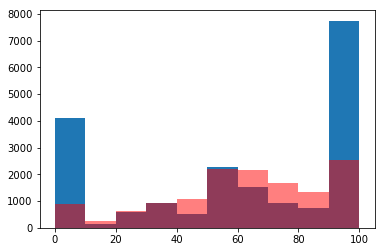

In [248]:
plt.hist(churndf['weekday_pct'])
plt.hist(retaindf['weekday_pct'], color='red', alpha=0.5)
plt.show()

## POTENTIAL DROPS - AVG DIST

### Split out y and X Data for train

In [302]:
formdf = df.copy()

y = formdf.pop('churn')
X = np.array(formdf)
X_norm = normalize(X)

### Import Test Data

In [303]:
testdf = pd.read_csv('data/churn_test.csv')
throwaway, testdf = clean_data(testdf)


y_test = testdf.pop('churn')
X_test = np.array(testdf)
X_test_norm = normalize(X_test)

# Logistic For P-Values

In [309]:
testdf.columns

Index([u'avg_dist', u'avg_rating_by_driver', u'avg_rating_of_driver',
       u'avg_surge', u'surge_pct', u'trips_in_first_30_days', u'weekday_pct',
       u'phone_iPhone', u'luxury_car_user_True', u'city_King's Landing',
       u'city_Winterfell'],
      dtype='object')

In [369]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.ensemble import AdaBoostClassifier

# F, pval = f_classif(X_norm, y)
# np.stack([F, pval], axis=1)

feature_list = []

for r in range(10, 12):
    combs = combinations(testdf.columns, r)
    print "WORKING ON R: {}".format(r)
    
    for features in combs:
        
        formdf = df.copy()

        y = formdf.pop('churn')
        X = np.array(formdf[list(features)])
        X_norm = normalize(X)

        testdf = pd.read_csv('data/churn_test.csv')
        throwaway, testdf = clean_data(testdf)


        y_test = testdf.pop('churn')
        X_test = np.array(testdf[list(features)])
        X_test_norm = normalize(X_test)


#         lr = LogisticRegression()
        lr = AdaBoostClassifier(learning_rate=1)
        fitted = lr.fit(X_norm, y)

        feature_list.append((list(features), lr.score(X_test_norm, y_test)))

feature_list.sort(key=lambda x: x[1])

WORKING ON R: 10
WORKING ON R: 11


In [370]:
feature_list[-10:]

[(['avg_dist',
   'avg_rating_by_driver',
   'avg_rating_of_driver',
   'avg_surge',
   'trips_in_first_30_days',
   'weekday_pct',
   'phone_iPhone',
   'luxury_car_user_True',
   "city_King's Landing",
   'city_Winterfell'],
  0.73751954769637917),
 (['avg_dist',
   'avg_rating_by_driver',
   'avg_rating_of_driver',
   'avg_surge',
   'surge_pct',
   'trips_in_first_30_days',
   'weekday_pct',
   'luxury_car_user_True',
   "city_King's Landing",
   'city_Winterfell'],
  0.73872248285817399),
 (['avg_dist',
   'avg_rating_by_driver',
   'avg_rating_of_driver',
   'avg_surge',
   'surge_pct',
   'trips_in_first_30_days',
   'weekday_pct',
   'phone_iPhone',
   "city_King's Landing",
   'city_Winterfell'],
  0.73932395043907129),
 (['avg_dist',
   'avg_rating_by_driver',
   'avg_rating_of_driver',
   'avg_surge',
   'surge_pct',
   'trips_in_first_30_days',
   'weekday_pct',
   'phone_iPhone',
   'luxury_car_user_True',
   "city_King's Landing"],
  0.74509803921568629),
 (['avg_dist',
 

# RandomForest

In [351]:
formdf.columns

Index([u'avg_dist', u'avg_rating_by_driver', u'avg_rating_of_driver',
       u'avg_surge', u'surge_pct', u'trips_in_first_30_days', u'weekday_pct',
       u'phone_iPhone', u'luxury_car_user_True', u'city_King's Landing',
       u'city_Winterfell'],
      dtype='object')

In [358]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# features = ['avg_dist',
#    'avg_rating_by_driver',
#    'avg_rating_of_driver',
#    'avg_surge',
#    'surge_pct',
#    'phone_iPhone',
#    'luxury_car_user_True',
#    "city_King's Landing",
#    'city_Winterfell']


# features = ['avg_dist',
#           'avg_rating_by_driver',
#           'trips_in_first_30_days',
#           'phone_iPhone',
#           'luxury_car_user_True',
#           "city_King's Landing",
#           "city_Winterfell"
#          ]


features = [
            'trips_in_first_30_days',
           ]

features = formdf.columns

formdf = df.copy()

y = formdf.pop('churn')
X = np.array(formdf[features])
X_norm = normalize(X)


testdf = pd.read_csv('data/churn_test.csv')
throwaway, testdf = clean_data(testdf)

y_test = testdf.pop('churn')
X_test = np.array(testdf[features])
X_test_norm = normalize(X_test)


params = {'n_estimators'       : [100],
          'criterion'          : ['gini'],
          'max_depth'          : [5, None],
          'min_samples_split'  : [2],
          'min_samples_leaf'   : [1],
          'max_features'       : ['auto', None],
          'bootstrap'          : [True],
          'n_jobs'             : [-1],
          'random_state'       : [0]
         }

rfc = RandomForestClassifier()

grfc = GridSearchCV(rfc, params, cv=5, n_jobs=-1, verbose=10)
grfc.fit(X_norm, y)


sorted(grfc.cv_results_.keys())

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] n_jobs=-1, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=auto, random_state=0, criterion=gini, min_samples_split=2, max_depth=5 
[CV] n_jobs=-1, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=auto, random_state=0, criterion=gini, min_samples_split=2, max_depth=5 
[CV] n_jobs=-1, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=auto, random_state=0, criterion=gini, min_samples_split=2, max_depth=5 
[CV] n_jobs=-1, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=auto, random_state=0, criterion=gini, min_samples_split=2, max_depth=5 
[CV]  n_jobs=-1, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=auto, random_state=0, criterion=gini, min_samples_split=2, max_depth=5, score=0.751660, total=   4.5s
[CV] n_jobs=-1, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=auto, random_state=0, criterion=gini, min_samples_s

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   10.5s


[CV]  n_jobs=-1, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=None, random_state=0, criterion=gini, min_samples_split=2, max_depth=5, score=0.747812, total=  14.0s
[CV] n_jobs=-1, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=None, random_state=0, criterion=gini, min_samples_split=2, max_depth=5 
[CV]  n_jobs=-1, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=None, random_state=0, criterion=gini, min_samples_split=2, max_depth=5, score=0.757242, total=  14.4s
[CV] n_jobs=-1, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=auto, random_state=0, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  n_jobs=-1, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=None, random_state=0, criterion=gini, min_samples_split=2, max_depth=5, score=0.756716, total=  14.3s
[CV] n_jobs=-1, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=auto, random_state=0, criterion=gini, min_samp

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   32.1s


[CV] n_jobs=-1, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=auto, random_state=0, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  n_jobs=-1, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=None, random_state=0, criterion=gini, min_samples_split=2, max_depth=5, score=0.757018, total=  13.9s
[CV] n_jobs=-1, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=None, random_state=0, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  n_jobs=-1, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=auto, random_state=0, criterion=gini, min_samples_split=2, max_depth=None, score=0.762904, total=  11.4s
[CV] n_jobs=-1, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=None, random_state=0, criterion=gini, min_samples_split=2, max_depth=None 
[CV]  n_jobs=-1, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=auto, random_state=0, criterion=gini, min_samples_split=2, max_dept

[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:  1.1min remaining:   16.8s


[CV]  n_jobs=-1, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=None, random_state=0, criterion=gini, min_samples_split=2, max_depth=None, score=0.743284, total=  31.9s
[CV]  n_jobs=-1, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=None, random_state=0, criterion=gini, min_samples_split=2, max_depth=None, score=0.752339, total=  30.8s
[CV]  n_jobs=-1, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=None, random_state=0, criterion=gini, min_samples_split=2, max_depth=None, score=0.747963, total=  30.8s
[CV]  n_jobs=-1, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=None, random_state=0, criterion=gini, min_samples_split=2, max_depth=None, score=0.752641, total=  14.7s


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.4min finished


['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_bootstrap',
 'param_criterion',
 'param_max_depth',
 'param_max_features',
 'param_min_samples_leaf',
 'param_min_samples_split',
 'param_n_estimators',
 'param_n_jobs',
 'param_random_state',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

In [ ]:
sorted(grfc.cv_results_['mean_test_score'])

In [ ]:
from sklearn.metrics import confusion_matrix

best = grfc.best_estimator_
y_pred = best.predict(X_test_norm)

confusion_matrix(y_test, y_pred)

In [349]:
from sklearn.feature_selection import f_classif

X = np.array(formdf)
X_norm = normalize(X)
labels = formdf.columns

newlist = []

fs, pval = f_classif(X, y)
for label, fs, pval in zip(labels, fs, pval):
    newlist.append((label, round(fs, 2), round(pval, 5)))
for value in newlist:
    print value
    
anova_features = ['avg_dist',
                  'avg_rating_by_driver',
                  'trips_in_first_30_days',
                  'phone_iPhone',
                  'luxury_car_user_True',
                  "city_King's Landing",
                  "city_Winterfell"
                 ]

('avg_dist', 279.51, 0.0)
('avg_rating_by_driver', 45.9, 0.0)
('avg_rating_of_driver', 5.85, 0.01555)
('avg_surge', 0.71, 0.40039)
('surge_pct', 3.72, 0.05362)
('trips_in_first_30_days', 1377.51, 0.0)
('weekday_pct', 3.51, 0.06094)
('phone_iPhone', 1948.22, 0.0)
('luxury_car_user_True', 1698.79, 0.0)
("city_King's Landing", 2334.35, 0.0)
('city_Winterfell', 52.59, 0.0)
